In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import sklearn as skt
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import re
import collections
from nltk.tokenize import RegexpTokenizer

In [2]:
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

# Chemin vers le fichier dans Google Drive
file_path = '/content/drive/My Drive/FakeNewsNet Dataset/gossipcop_real.csv'

# Charger le fichier CSV
true_df = pd.read_csv(file_path)

# Vérification des premières lignes du dataframe
true_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,news_url,title,tweet_ids
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,912371411146149888\t912371528343408641\t912372...
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,901989917546426369\t901989992074969089\t901990...
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,931263637246881792\t931265332022579201\t931265...
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,868114761723936769\t868122567910936576\t868128...
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,915528047004209152\t915529285171122176\t915530...


In [3]:
# Chemin vers le fichier dans Google Drive
file_path = '/content/drive/My Drive/FakeNewsNet Dataset/gossipcop_fake.csv'

# Charger le fichier CSV
fake_df = pd.read_csv(file_path)
fake_df.head()

,id,news_url,title,tweet_ids
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...


# Data Preprocessing

Preprocessing of true and fake datasets for data optimisation and removal of blank and duplicate entries.

## Verified News Dataset

In [4]:
# TRUE DATASET
# Checking for NaN values
true_df.isna().sum()

,0
id,0
news_url,13
title,0
tweet_ids,1058


In [5]:
true_df['title']

,title
0,Teen Mom Star Jenelle Evans' Wedding Dress Is ...
1,Kylie Jenner refusing to discuss Tyga on Life ...
2,Quinn Perkins
3,I Tried Kim Kardashian's Butt Workout & Am For...
4,Celine Dion donates concert proceeds to Vegas ...
...,...
16812,2017 Hollywood Film Awards: The Complete List ...
16813,Jada Pinkett Smith explains why son Jaden move...
16814,Tinsley Mortimer Reacts to Luann de Lesseps' R...
16815,Prince Harry Carries on Princess Diana’s Legac...


In [6]:
# Define function for most common words
# https://github.com/remydeshayes/NLP_Pytorch/blob/main/Notebook%20-%20Fake_News%20Detection%20Pytorch%20-%20Billiot_Deshayes.ipynb
from collections import Counter


def most_common(corpus, nb_words):
    articles = corpus.str.split()
    # Explanation of nested list comprehension:
    # Iterate through every article in articles
    # Iterate through every word in article (second for in loop)
    # Add word to the np.array if it is not a stopword (nltk)
    words = np.array([word for article in articles for word in article if word.lower() not in stopwords])
    counter = Counter(words)
    d = pd.DataFrame(counter, index=['occurences']).transpose().reset_index()
    d.columns = ['word', 'occurences']
    d = d.sort_values('occurences', ascending=False)
    return d[:nb_words]

In [7]:
# Download stopwords from nltk library
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# This is VERY HIGH cpu compute (but it only takes a few seconds)
most_common(true_df['title'], 10)

,word,occurences
22,&,752
335,New,620
192,Kardashian,561
339,2018,524
66,Awards,489
52,Season,477
18,Kim,410
252,Prince,381
73,First,351
688,Meghan,348


In [9]:
# Check for duplicates or blank articles
# Conversion to dataframe to reduce output text clutter
duplicate = true_df['title'].value_counts()[true_df['title'].value_counts()>1]
duplicate = duplicate.rename_axis('unique_values').reset_index(name='counts')
duplicate

,unique_values,counts
0,- USweekly,12
1,This Is Us: Sterling K Brown Tells Us Why Rand...,11
2,Wedding of Prince Harry and Meghan Markle,9
3,Celebritymaximum.com,8
4,Why Nikki Bella Hid Her First Marriage from Jo...,8
...,...,...
556,14 Signs Bella Hadid and The Weeknd Are Gettin...,2
557,This Is Us (season 2),2
558,‘Dancing With the Stars’ finale: Why no one ha...,2
559,Zac Efron Confirms That He Can Sing in The Gre...,2


In [10]:
# Number of duplicate entries
true_df['title'].value_counts()[true_df['title'].value_counts()>1].sum() - 212

1199

In [11]:
# Deletion of duplicates
true_df = true_df.drop_duplicates(subset=['title'], ignore_index=True)

In [12]:
true_df.shape

(15967, 4)

In [13]:
true_df

,id,news_url,title,tweet_ids
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,912371411146149888\t912371528343408641\t912372...
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,901989917546426369\t901989992074969089\t901990...
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,931263637246881792\t931265332022579201\t931265...
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,868114761723936769\t868122567910936576\t868128...
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,915528047004209152\t915529285171122176\t915530...
...,...,...,...,...
15962,gossipcop-891749,https://omgcheckitout.com/2017-hollywood-film-...,2017 Hollywood Film Awards: The Complete List ...,927385466357260288\t927386601034010625\t927387...
15963,gossipcop-941486,https://pagesix.com/2018/06/04/jada-pinkett-sm...,Jada Pinkett Smith explains why son Jaden move...,1004044947006386178\t1004045964401889285\t1004...
15964,gossipcop-953143,https://www.etonline.com/tinsley-mortimer-reac...,Tinsley Mortimer Reacts to Luann de Lesseps' R...,1019924845889572864\t1019925702676709377\t1019...
15965,gossipcop-954366,https://www.healthbreakingnews.net/2018/07/pri...,Prince Harry Carries on Princess Diana’s Legac...,1021766291139584000\t1021772054599802880\t1021...


Finally creating a label variable - 1 means the news is verified

In [14]:
true_df['real'] = 1
true_df['fake'] = 0

In [15]:
fake_df['label'] = 0

In [16]:
true_df

,id,news_url,title,tweet_ids,real,fake
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,912371411146149888\t912371528343408641\t912372...,1,0
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,901989917546426369\t901989992074969089\t901990...,1,0
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,931263637246881792\t931265332022579201\t931265...,1,0
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,868114761723936769\t868122567910936576\t868128...,1,0
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,915528047004209152\t915529285171122176\t915530...,1,0
...,...,...,...,...,...,...
15962,gossipcop-891749,https://omgcheckitout.com/2017-hollywood-film-...,2017 Hollywood Film Awards: The Complete List ...,927385466357260288\t927386601034010625\t927387...,1,0
15963,gossipcop-941486,https://pagesix.com/2018/06/04/jada-pinkett-sm...,Jada Pinkett Smith explains why son Jaden move...,1004044947006386178\t1004045964401889285\t1004...,1,0
15964,gossipcop-953143,https://www.etonline.com/tinsley-mortimer-reac...,Tinsley Mortimer Reacts to Luann de Lesseps' R...,1019924845889572864\t1019925702676709377\t1019...,1,0
15965,gossipcop-954366,https://www.healthbreakingnews.net/2018/07/pri...,Prince Harry Carries on Princess Diana’s Legac...,1021766291139584000\t1021772054599802880\t1021...,1,0


## False News Dataset

In [17]:
# FAKE DATASET
# Checking for NaN values
fake_df.isna().sum()

,0
id,0
news_url,256
title,0
tweet_ids,188
label,0


In [18]:
# Check for duplicates or blank articles
# Conversion to dataframe to reduce output textitlet clutter
duplicate = fake_df['title'].value_counts()[fake_df['title'].value_counts()>1]
duplicate = duplicate.rename_axis('unique_values').reset_index(name='counts')
duplicate

,unique_values,counts
0,Connecting People Through News,20
1,Female First Forum,11
2,Brad Pitt and Jennifer Aniston 'busted' over A...,8
3,Jennifer Lopez Is Questioning Her Future With ...,6
4,Gwen Stefani Is Still Smitten With Blake Shelt...,6
...,...,...
290,Liam Hemsworth,2
291,Actor Tom Cruise Proposes to Girlfriend Katie ...,2
292,A Timeline of the Complicated Relationship Bet...,2
293,Brad Pitt fires back at Angelina Jolie's child...,2


In [19]:
fake_df['title'].value_counts()[fake_df['title'].value_counts()>1].sum() - 4927 - 626

-4831

In [20]:
# Values with no text - only title
blank = fake_df.loc[fake_df["title"] == duplicate["unique_values"][0]]
blank

,id,news_url,title,tweet_ids,label
408,gossipcop-5793704644,www.pressreader.com/india/the-sunday-guardian/...,Connecting People Through News,822376317953843200\t822376774164090880\t822377...,0
1006,gossipcop-8293006687,www.pressreader.com/new-zealand/womans-day-nz/...,Connecting People Through News,900336607680761857\t900407896072216576\t900412...,0
1079,gossipcop-9080361625,www.pressreader.com/usa/in-touch-usa/20180323/...,Connecting People Through News,895585055690575872\t895672153496051712\t895784...,0
1779,gossipcop-8328156845,www.pressreader.com/usa/life-style-weekly/2018...,Connecting People Through News,900336607680761857\t900407896072216576\t900412...,0
3059,gossipcop-9955703756,www.pressreader.com/australia/womans-day-austr...,Connecting People Through News,900336607680761857\t900407896072216576\t900412...,0
3069,gossipcop-8049563330,www.pressreader.com/australia/nw/20180430/2835...,Connecting People Through News,900336607680761857\t900407896072216576\t900412...,0
3358,gossipcop-905546659,www.pressreader.com/australia/nw/20180305/2841...,Connecting People Through News,857607295668289536\t857746231967318018\t858053...,0
3638,gossipcop-5650911362,www.pressreader.com/usa/life-style-weekly/2018...,Connecting People Through News,903251560905547777\t903275410527420416\t903409...,0
3671,gossipcop-3264479815,www.pressreader.com/australia/ok-australia/201...,Connecting People Through News,900336607680761857\t900407896072216576\t900412...,0
3725,gossipcop-5660970075,www.pressreader.com/new-zealand/womans-day-nz/...,Connecting People Through News,900336607680761857\t900407896072216576\t900412...,0


In [21]:
blank.index

Index([ 408, 1006, 1079, 1779, 3059, 3069, 3358, 3638, 3671, 3725, 3777, 3877,
       4034, 4122, 4166, 4186, 4228, 4485, 5074, 5269],
      dtype='int64')

In [22]:
# Dropping the blank news from the fake dataframe
fake_df = fake_df.drop(blank.index)

In [23]:
# Verification of removal (verified)
fake_df

,id,news_url,title,tweet_ids,label
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...,0
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...,0
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...,0
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...,0
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...,0
...,...,...,...,...,...
5318,gossipcop-6702260693,www.huffingtonpost.com/2012/09/11/september-11...,September 11: Celebrities Remember 9/11 (TWEETS),245643768638894080,0
5319,gossipcop-6051845337,www.dailymail.co.uk/news/article-4915674/NASCA...,NASCAR owners threaten to fire drivers who pro...,912048333413330944\t912048571482087424\t912049...,0
5320,gossipcop-2435526162,www.telegraph.co.uk/men/the-filter/7-signs-dav...,The 7 signs that David Beckham is definitely h...,897794716447539200\t897804460830928896\t897842...,0
5321,gossipcop-4576152851,www.vanityfair.com/style/2016/09/ryan-gosling-...,Ryan Gosling and Eva Mendes Did Not Get Marrie...,778678901572710400\t778681718714740736\t778683...,0


In [24]:
# Deletion of duplicates
fake_df = fake_df.drop_duplicates(subset=['title'], ignore_index=True)

In [25]:
fake_df

,id,news_url,title,tweet_ids,label
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...,0
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...,0
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...,0
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...,0
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...,0
...,...,...,...,...,...
4890,gossipcop-6702260693,www.huffingtonpost.com/2012/09/11/september-11...,September 11: Celebrities Remember 9/11 (TWEETS),245643768638894080,0
4891,gossipcop-6051845337,www.dailymail.co.uk/news/article-4915674/NASCA...,NASCAR owners threaten to fire drivers who pro...,912048333413330944\t912048571482087424\t912049...,0
4892,gossipcop-2435526162,www.telegraph.co.uk/men/the-filter/7-signs-dav...,The 7 signs that David Beckham is definitely h...,897794716447539200\t897804460830928896\t897842...,0
4893,gossipcop-4576152851,www.vanityfair.com/style/2016/09/ryan-gosling-...,Ryan Gosling and Eva Mendes Did Not Get Marrie...,778678901572710400\t778681718714740736\t778683...,0


In [26]:
fake_df['real'] = 0
fake_df['fake'] = 1

<ipython-input-26-67d463e65983>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df['real'] = 0
<ipython-input-26-67d463e65983>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df['fake'] = 1


In [27]:
fake_df['label'] = 0

<ipython-input-27-26339418ee6c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df['label'] = 0


Finally we concatenate both the dataframe

In [28]:
data = pd.concat([true_df, fake_df])
data = data.reset_index(drop=True)

In [29]:
data

,id,news_url,title,tweet_ids,real,fake,label
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,912371411146149888\t912371528343408641\t912372...,1,0,NaN
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,901989917546426369\t901989992074969089\t901990...,1,0,NaN
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,931263637246881792\t931265332022579201\t931265...,1,0,NaN
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,868114761723936769\t868122567910936576\t868128...,1,0,NaN
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,915528047004209152\t915529285171122176\t915530...,1,0,NaN
...,...,...,...,...,...,...,...
20857,gossipcop-6702260693,www.huffingtonpost.com/2012/09/11/september-11...,September 11: Celebrities Remember 9/11 (TWEETS),245643768638894080,0,1,0.0
20858,gossipcop-6051845337,www.dailymail.co.uk/news/article-4915674/NASCA...,NASCAR owners threaten to fire drivers who pro...,912048333413330944\t912048571482087424\t912049...,0,1,0.0
20859,gossipcop-2435526162,www.telegraph.co.uk/men/the-filter/7-signs-dav...,The 7 signs that David Beckham is definitely h...,897794716447539200\t897804460830928896\t897842...,0,1,0.0
20860,gossipcop-4576152851,www.vanityfair.com/style/2016/09/ryan-gosling-...,Ryan Gosling and Eva Mendes Did Not Get Marrie...,778678901572710400\t778681718714740736\t778683...,0,1,0.0


In [30]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

print("Number of words in dataset:", data['title'].apply(lambda x: len(x.split(' '))).sum())

Number of words in dataset: 236717


In [31]:
data.iloc[0,0:]

,0
id,gossipcop-882573
news_url,https://www.brides.com/story/teen-mom-jenelle-...
title,Teen Mom Star Jenelle Evans' Wedding Dress Is ...
tweet_ids,912371411146149888\t912371528343408641\t912372...
real,1
fake,0
label,NaN


In [32]:
number_of_samples=data.iloc[:,0].count()

In [33]:
y=data.iloc[:,8:].sum(axis=1).value_counts()/data.iloc[:,0].count()*100

# Exploratory Data Analysis

In [34]:
# Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-35-5b14143a0517>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(y='Average character length', x='Label', data=av, palette=colors)


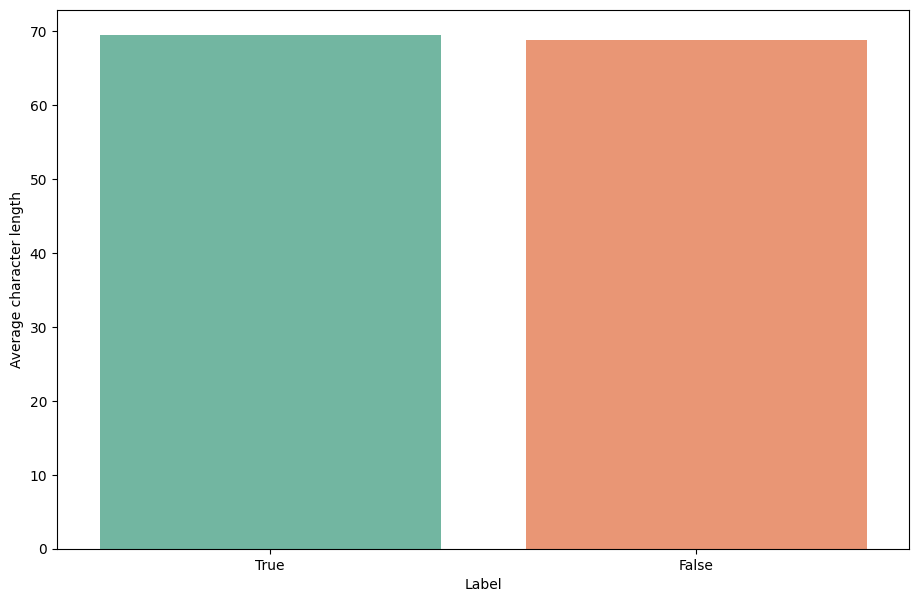

In [35]:
# Text analysis
av_t = data[data['real'] == 1]['title'].apply(lambda x: len(x)).mean()
av_f = data[data['fake'] == 1]['title'].apply(lambda x: len(x)).mean()
av = pd.DataFrame(data = {'Average character length': [av_t, av_f], 'Label':['True', 'False']})
fig, bar = plt.subplots(figsize = (11,7))

colors = sns.color_palette("Set2", 2)

bar = sns.barplot(y='Average character length', x='Label', data=av, palette=colors)

### Most common words

<ipython-input-36-413c5872692d>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(l0))), y=h0, ax=ax[0], palette=colors);
<ipython-input-36-413c5872692d>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(l1))), y=h1, ax=ax[1], palette=colors);


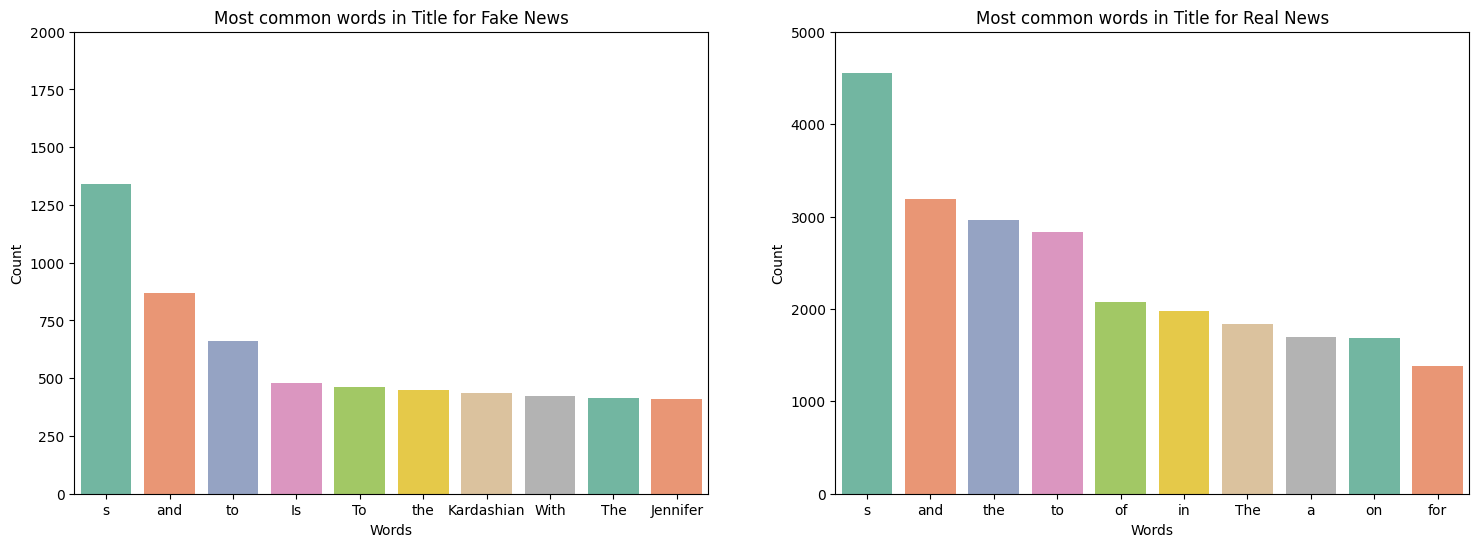

In [36]:

def get_wrd_count(text_lst):
    all_wrds = []
    tokenizer = RegexpTokenizer(r'\w+')
    for txt in text_lst:
        wrds = tokenizer.tokenize(txt)
        all_wrds.extend(wrds)
    wrd_counter = collections.Counter(all_wrds)
    return wrd_counter

fake_titles = data[data['fake']== 1]['title'].tolist()
real_titles = data[data['real']==1]['title'].tolist()

# word count

fake0_wrd = get_wrd_count(fake_titles)
real1_wrd = get_wrd_count(real_titles)

fake0_wrd_cnt_sorted = fake0_wrd.most_common(n=10)
real1_wrd_cnt_sorted = real1_wrd.most_common(n=10)
l0, h0, l1, h1 = [],[],[],[]
_ = [(l0.append(i[0]), h0.append(i[1])) for i in fake0_wrd_cnt_sorted]
_ = [(l1.append(i[0]), h1.append(i[1])) for i in real1_wrd_cnt_sorted]
#print(l1, h1)

colors = sns.color_palette("Set2", 10)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6));
sns.barplot(x=list(range(len(l0))), y=h0, ax=ax[0], palette=colors);
ax[0].set_ylim(top=2000);
ax[0].set_xticks(ticks = list(range(len(l0))));
ax[0].set_xticklabels(l0);
ax[0].set_xlabel('Words');
ax[0].set_ylabel('Count');
ax[0].set_title("Most common words in Title for Fake News");

sns.barplot(x=list(range(len(l1))), y=h1, ax=ax[1], palette=colors);
ax[1].set_ylim(top=5000);
ax[1].set_xticks(ticks = list(range(len(l1))));
ax[1].set_xticklabels(l1);
ax[1].set_xlabel('Words');
ax[1].set_ylabel('Count');
ax[1].set_title("Most common words in Title for Real News");

# Text Pre-processing

In [37]:
pip install unidecode

In [38]:
pip install autocorrect

In [39]:
# Importing Libraries
import unidecode
import pandas as pd
import re
import time
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk import word_tokenize
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
def remove_hash(text1):
      return text1.replace("''", "")

In [41]:
def remove_tag(text2):
      return text2.replace("'", "")

In [42]:
def remove_tag(text3):
      return text3.replace("'", "")

In [43]:
def remove_underscore(text):
      return text.replace("_", " ")

In [44]:
data['title']=data['title'].apply(lambda text1: remove_hash(text1))

In [45]:
data['title']=data['title'].apply(lambda text2: remove_tag(text2))

In [46]:
data['title']=data['title'].apply(lambda text3: remove_tag(text3))

In [47]:
data['title']=data['title'].apply(lambda text: remove_underscore(text))

# Remove newlines & Tabs

In [48]:
def remove_newlines_tabs(text):
    """
    This function will remove all the occurrences of newlines, tabs, and combinations like: \\n, \\.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" after removal of newlines, tabs, \\n, \\ characters.

    Example:
    Input : This is her \\ first day at this place.\n Please,\t Be nice to her.\\n
    Output : This is her first day at this place. Please, Be nice to her.
    """

    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    Formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
    return Formatted_text

In [49]:
data['title']=data['title'].apply(remove_newlines_tabs)

# Strip HTML Tags

In [50]:
def strip_html_tags(text):
    """
    This function will remove all the occurrences of html tags from the text.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" after removal of html tags.

    Example:
    Input : This is a nice place to live. <IMG>
    Output : This is a nice place to live.
    """
    # Initiating BeautifulSoup object soup.
    soup = BeautifulSoup(text, "html.parser")
    # Get all the text other than html tags.
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

In [51]:
data['title']=data['title'].apply(strip_html_tags)

<ipython-input-50-e98537e2dbe3>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


# Remove Links

In [52]:
def remove_links(text):
    """
    This function will remove all the occurrences of links.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" after removal of all types of links.

    Example:
    Input : To know more about this website: kajalyadav.com  visit: https://kajalyadav.com//Blogs
    Output : To know more about this website: visit:

    """

    # Removing all the occurrences of links that starts with https
    remove_https = re.sub(r'http\S+', '', text)
    # Remove all the occurrences of text that ends with .com
    remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
    return remove_com

In [53]:
data['title']=data['title'].apply(remove_links)

# Remove Accented Characters

In [54]:
# Code for accented characters removal
def accented_characters_removal(text):
    # this is a docstring
    """
    The function will remove accented characters from the
    text contained within the Dataset.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" with removed accented characters.

    Example:
    Input : Málaga, àéêöhello
    Output : Malaga, aeeohello

    """
    # Remove accented characters from text using unidecode.
    # Unidecode() - It takes unicode data & tries to represent it to ASCII characters.
    text = unidecode.unidecode(text)
    return text

In [55]:
data['title']=data['title'].apply(accented_characters_removal)

# Expand Contractions

In [56]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
}
# The code for expanding contraction words
def expand_contractions(text, contraction_mapping =  CONTRACTION_MAP):
    """expand shortened words to the actual form.
       e.g. don't to do not

       arguments:
            input_text: "text" of type "String".

       return:
            value: Text with expanded form of shorthened words.

       Example:
       Input : ain't, aren't, can't, cause, can't've
       Output :  is not, are not, cannot, because, cannot have

     """
    # Tokenizing text into tokens.
    list_Of_tokens = text.split(' ')

    # Checking for whether the given token matches with the Key & replacing word with key's value.

    # Check whether Word is in lidt_Of_tokens or not.
    for Word in list_Of_tokens:
        # Check whether found word is in dictionary "Contraction Map" or not as a key.
         if Word in CONTRACTION_MAP:
                # If Word is present in both dictionary & list_Of_tokens, replace that word with the key value.
                list_Of_tokens = [item.replace(Word, CONTRACTION_MAP[Word]) for item in list_Of_tokens]

    # Converting list of tokens to String.
    String_Of_tokens = ' '.join(str(e) for e in list_Of_tokens)
    return String_Of_tokens

In [57]:
data['title']=data['title'].apply(expand_contractions)

## Removing special characters except (!,?)

In [58]:
# The code for removing special characters except (!,?)
def removing_special_characters(text):
    """Removing all the special characters except the one that is passed within
       the regex to match, as they have imp meaning in the text provided.


    arguments:
         input_text: "text" of type "String".

    return:
        value: Text with removed special characters that don't require.

    Example:
    Input : Hello, K-a-j-a-l. Thi*s is $100.05 : the payment that you will recieve! (Is this okay?)
    Output :  Hello, Kajal. This is $100.05 : the payment that you will recieve! Is this okay?

   """
    # The formatted text after removing not necessary punctuations.
    Formatted_Text = re.sub(r"[^a-zA-Z0-9:$-,%.@_#""'']+", ' ', text)
    # In the above regex expression,I am providing necessary set of punctuations that are frequent in this particular dataset.
    return Formatted_Text

In [59]:
data['title']=data['title'].apply(removing_special_characters)

In [60]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [61]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Removing stopwords

In [62]:
# The code for removing stopwords
stoplist = stopwords.words('english')
stoplist = set(stoplist)
def removing_stopwords(text):
    """This function will remove stopwords which doesn't add much meaning to a sentence
       & they can be remove safely without comprimising meaning of the sentence.

    arguments:
         input_text: "text" of type "String".

    return:
        value: Text after omitted all stopwords.

    Example:
    Input : This is Kajal from delhi who came here to study.
    Output : ["'This", 'Kajal', 'delhi', 'came', 'study', '.', "'"]

   """
    # repr() function actually gives the precise information about the string
    text = repr(text)
    # Text without stopwords
    No_StopWords = [word for word in word_tokenize(text) if word.lower() not in stoplist ]
    # Convert list of tokens_without_stopwords to String type.
    words_string = ' '.join(No_StopWords)
    return words_string

In [63]:
data['title']=data['title'].apply(removing_stopwords)

data.to_csv('data1.csv', index=False)

# Most frequent words

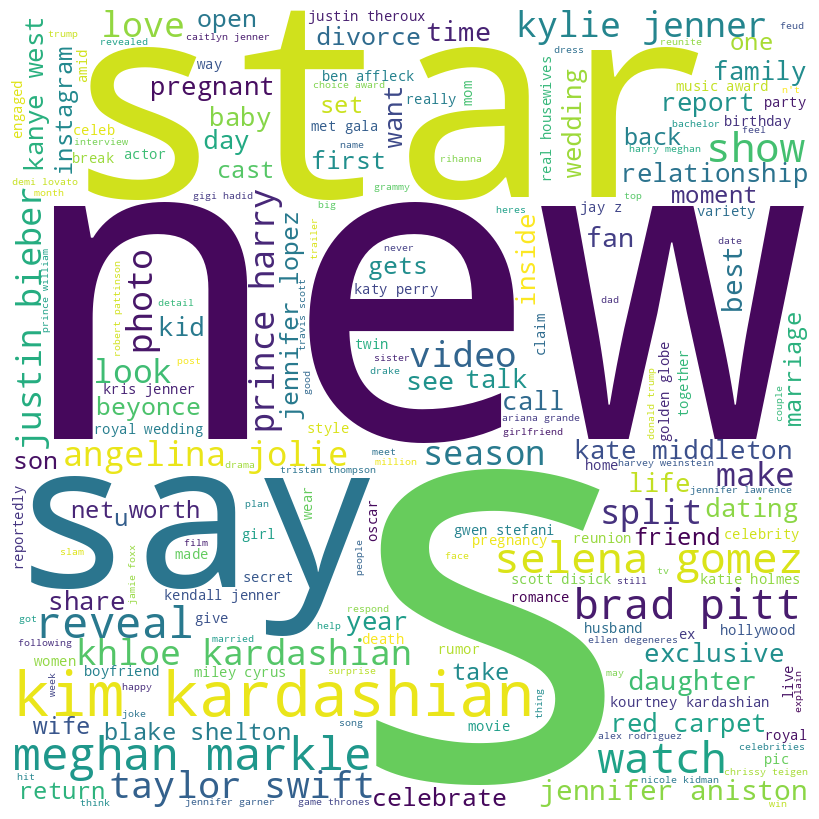

In [64]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Reads
df = data

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.title:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10,
                      font_path=None).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [65]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from sklearn.feature_extraction.text import CountVectorizer

# Fonction pour obtenir les bigrammes les plus fréquents
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Obtenir les 20 bigrammes les plus fréquents
common_words = get_top_n_bigram(data['title'], 20)
for word, freq in common_words:
    print(word, freq)

kim kardashian 476
meghan markle 389
selena gomez 368
brad pitt 359
taylor swift 289
kylie jenner 288
khloe kardashian 283
angelina jolie 283
justin bieber 271
prince harry 267
jennifer aniston 255
red carpet 209
kanye west 206
kate middleton 173
net worth 167
blake shelton 162
jennifer lopez 161
katy perry 147
scott disick 143
gwen stefani 141


<ipython-input-66-fb43d2c50788>:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-66-fb43d2c50788>:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




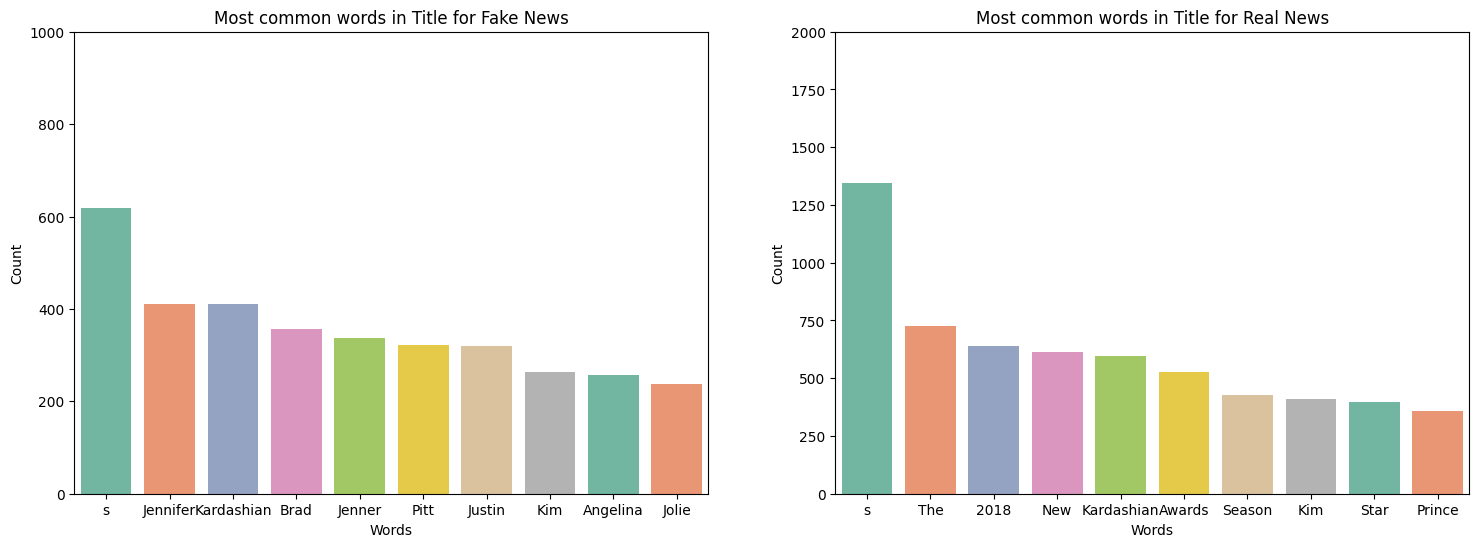

In [66]:
def get_wrd_count(text_lst):
    all_wrds = []
    tokenizer = RegexpTokenizer(r'\w+')
    for txt in text_lst:
        wrds = tokenizer.tokenize(txt)
        all_wrds.extend(wrds)
    wrd_counter = collections.Counter(all_wrds)
    return wrd_counter

fake_titles = data[data['fake']== 1]['title'].tolist()
real_titles = data[data['real']==1]['title'].tolist()

# word count

fake0_wrd = get_wrd_count(fake_titles)
real1_wrd = get_wrd_count(real_titles)

fake0_wrd_cnt_sorted = fake0_wrd.most_common(n=10)
real1_wrd_cnt_sorted = real1_wrd.most_common(n=10)
l0, h0, l1, h1 = [],[],[],[]
_ = [(l0.append(i[0]), h0.append(i[1])) for i in fake0_wrd_cnt_sorted]
_ = [(l1.append(i[0]), h1.append(i[1])) for i in real1_wrd_cnt_sorted]
#print(l1, h1)

colors = sns.color_palette("Set2", 10)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6));
sns.barplot(x=list(range(len(l0))), y=h0, ax=ax[0], palette=colors);
ax[0].set_ylim(top=1000);
ax[0].set_xticks(ticks = list(range(len(l0))));
ax[0].set_xticklabels(l0);
ax[0].set_xlabel('Words');
ax[0].set_ylabel('Count');
ax[0].set_title("Most common words in Title for Fake News");

sns.barplot(x=list(range(len(l1))), y=h1, ax=ax[1], palette=colors);
ax[1].set_ylim(top=2000);
ax[1].set_xticks(ticks = list(range(len(l1))));
ax[1].set_xticklabels(l1);
ax[1].set_xlabel('Words');
ax[1].set_ylabel('Count');
ax[1].set_title("Most common words in Title for Real News");

In [67]:
data2 = data[['id', 'news_url', 'title', 'label']]

In [68]:
from textblob import TextBlob, Word, Blobber

In [69]:
data2['polarity'] = data2['title'].map(lambda text: TextBlob(text).sentiment.polarity)

In [70]:
data2.head(4)

,id,news_url,title,label,polarity
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,'Teen Mom Star Jenelle Evans Wedding Dress Ava...,NaN,0.2
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,'Kylie Jenner refusing discuss Tyga Life Kylie ',NaN,0.0
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,'Quinn Perkins ',NaN,0.0
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,' Tried Kim Kardashians Butt Workout & Forever...,NaN,0.0


### Define score range for positive and negative

In [71]:
def classify_sentiment(value):
    if value < 0:
        return 'negative'
    elif value > 0:
        return 'positive'
    else:
        return 'neutre'

data2['sentiment'] = data2['polarity'].apply(classify_sentiment)
data2.tail()

,id,news_url,title,label,polarity,sentiment
20857,gossipcop-6702260693,www.huffingtonpost.com/2012/09/11/september-11...,'September 11 : Celebrities Remember 9 11 ( TW...,0.0,0.00,neutre
20858,gossipcop-6051845337,www.dailymail.co.uk/news/article-4915674/NASCA...,'NASCAR owners threaten fire drivers protest ',0.0,0.00,neutre
20859,gossipcop-2435526162,www.telegraph.co.uk/men/the-filter/7-signs-dav...,'The 7 signs David Beckham definitely midlife ...,0.0,0.00,neutre
20860,gossipcop-4576152851,www.vanityfair.com/style/2016/09/ryan-gosling-...,'Ryan Gosling Eva Mendes Get Married Updated ',0.0,0.25,positive
20861,gossipcop-919334865,www.lifeandstylemag.com/posts/jamie-foxx-katie...,'Jamie Foxx Spends Day Katie Holmes Suri Cruis...,0.0,0.25,positive


In [72]:
data2 = data2[['id', 'news_url', 'title','polarity','sentiment']]

In [73]:
data2

,id,news_url,title,polarity,sentiment
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,'Teen Mom Star Jenelle Evans Wedding Dress Ava...,0.20,positive
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,'Kylie Jenner refusing discuss Tyga Life Kylie ',0.00,neutre
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,'Quinn Perkins ',0.00,neutre
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,' Tried Kim Kardashians Butt Workout & Forever...,0.00,neutre
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,'Celine Dion donates concert proceeds Vegas sh...,0.00,neutre
...,...,...,...,...,...
20857,gossipcop-6702260693,www.huffingtonpost.com/2012/09/11/september-11...,'September 11 : Celebrities Remember 9 11 ( TW...,0.00,neutre
20858,gossipcop-6051845337,www.dailymail.co.uk/news/article-4915674/NASCA...,'NASCAR owners threaten fire drivers protest ',0.00,neutre
20859,gossipcop-2435526162,www.telegraph.co.uk/men/the-filter/7-signs-dav...,'The 7 signs David Beckham definitely midlife ...,0.00,neutre
20860,gossipcop-4576152851,www.vanityfair.com/style/2016/09/ryan-gosling-...,'Ryan Gosling Eva Mendes Get Married Updated ',0.25,positive


In [74]:
stm_dic =  {'positive':1, 'neutre':1, 'negative':0}
data2['sentiment'] = data2['sentiment'].replace(stm_dic)

<ipython-input-74-9747fb8f2043>:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [75]:
data2

,id,news_url,title,polarity,sentiment
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,'Teen Mom Star Jenelle Evans Wedding Dress Ava...,0.20,1
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,'Kylie Jenner refusing discuss Tyga Life Kylie ',0.00,1
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,'Quinn Perkins ',0.00,1
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,' Tried Kim Kardashians Butt Workout & Forever...,0.00,1
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,'Celine Dion donates concert proceeds Vegas sh...,0.00,1
...,...,...,...,...,...
20857,gossipcop-6702260693,www.huffingtonpost.com/2012/09/11/september-11...,'September 11 : Celebrities Remember 9 11 ( TW...,0.00,1
20858,gossipcop-6051845337,www.dailymail.co.uk/news/article-4915674/NASCA...,'NASCAR owners threaten fire drivers protest ',0.00,1
20859,gossipcop-2435526162,www.telegraph.co.uk/men/the-filter/7-signs-dav...,'The 7 signs David Beckham definitely midlife ...,0.00,1
20860,gossipcop-4576152851,www.vanityfair.com/style/2016/09/ryan-gosling-...,'Ryan Gosling Eva Mendes Get Married Updated ',0.25,1


In [76]:
data2['sentiment'].value_counts()

,count
sentiment,
1,18037
0,2825


In [77]:
data2.fillna(value='', inplace=True)

# BERT Model

In [78]:
import random, time
from babel.dates import format_date, format_datetime, format_time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score

import torch
from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

import transformers, os
from transformers import BertModel, AutoModel, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification

In [79]:
# Check device
# Get the GPU device name if available.
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

torch.cuda.empty_cache()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

There are %d GPU(s) available. 1
We will use the GPU: Tesla T4


In [80]:
# Split test and train data using 25% of the dataset for validation purposes
x_train, x_test, y_train, y_test = train_test_split(data2['title'],
                                                      data2['sentiment'], test_size=0.25, shuffle=True, random_state=42)

In [81]:
# Obtain a 10% test set from train set
X_train_Transformer, X_val_Transformer, y_train_Transformer, y_val_Transformer = train_test_split(
                                                    x_train, y_train, test_size=0.20, random_state=42)

In [82]:
print(np.unique(y_train))  # Check unique labels


[0 1]


In [83]:
model_name = 'bert-base-uncased'
SEQ_LEN = 200
batch_size = 64
epochs = 10
learning_rate = 1e-5 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = 20
num_workers = 3

In [84]:
def get_split(text1):
    '''Get split of the text with 300 char lenght'''
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else:
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return str(l_total)

# Splits train and validation sets to be feed to the transformer which only accepts 512 tokens maximum
split_train_text = [get_split(t) for t in X_train_Transformer]
split_valid_text = [get_split(t) for t in X_val_Transformer]
split_test_text = [get_split(t) for t in x_test]

In [85]:
from transformers import BertTokenizer, TFBertModel

# Load the RoBERTa tokenizer and tokenize the data
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [86]:
trencoding = tokenizer.batch_encode_plus(
  list(split_train_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

valencoding = tokenizer.batch_encode_plus(
  list(split_valid_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)


testencoding = tokenizer.batch_encode_plus(
  list(split_test_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

In [87]:
tokenizer.special_tokens_map


{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [88]:
trencoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

### Find Class Weights¶

In [89]:
# Example usage
class_wts = compute_class_weight(
    class_weight='balanced',               # This argument specifies that weights should be computed based on class frequencies.
    classes=np.unique(data2['sentiment'].values.tolist()), # Unique classes in your data
    y=data2['sentiment']                   # The target labels
)

print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
#cross_entropy  = nn.NLLLoss(weight=weights)
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

[3.69238938 0.57831125]


In [90]:
def loadData(prep_df, batch_size, num_workers, sampler):

    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=True
        )

## convert lists to tensors
train_seq = torch.tensor(trencoding['input_ids'])
train_mask = torch.tensor(trencoding['attention_mask'])
train_token_ids = torch.tensor(trencoding['token_type_ids'])
train_sentiment_scores = torch.tensor(y_train_Transformer.values, dtype=torch.float32).unsqueeze(1)
train_y = torch.tensor(y_train_Transformer.tolist())

val_seq = torch.tensor(valencoding['input_ids'])
val_mask = torch.tensor(valencoding['attention_mask'])
val_token_ids = torch.tensor(valencoding['token_type_ids'])
val_sentiment_scores = torch.tensor(y_val_Transformer.values, dtype=torch.float32).unsqueeze(1)
val_y = torch.tensor(y_val_Transformer.tolist())

test_seq = torch.tensor(testencoding['input_ids'])
test_mask = torch.tensor(testencoding['attention_mask'])
test_token_ids = torch.tensor(testencoding['token_type_ids'])
test_sentiment_scores = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
test_y = torch.tensor(y_test.tolist())

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_token_ids, train_sentiment_scores, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# Train Data Loader
traindata = loadData(train_data, batch_size, num_workers, train_sampler)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_token_ids, val_sentiment_scores, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# Val Data Loader
valdata = loadData(val_data, batch_size, num_workers, val_sampler)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_sentiment_scores, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)


print('Number of data in the train set', len(traindata))
print('Number of data in the validation set', len(valdata))
print('Number of data in the test set', len(testdata))

Number of data in the train set 196
Number of data in the validation set 49
Number of data in the test set 82


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



## Load BERT model¶

In [91]:
class BERT_Arch(nn.Module):
    def __init__(self, n_classes, freeze_bert=False):
        super(BERT_Arch, self).__init__()
        # Charger le modèle BERT pré-entraîné
        self.bert = BertModel.from_pretrained(model_name, return_dict=False)

        # Geler certaines couches de BERT (par exemple, les 6 premières)
        if freeze_bert:
            for name, param in self.bert.named_parameters():
                if 'encoder.layer.0' in name or 'encoder.layer.1' in name or 'encoder.layer.2' in name or 'encoder.layer.3' in name or 'encoder.layer.4' in name or 'encoder.layer.5' in name:
                    param.requires_grad = False

        # Dropout et fully connected layers
        self.bert_drop_1 = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size + 1, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 16)  # Ajout d'une deuxième couche fully-connected
        self.bn = nn.BatchNorm1d(16)  # Normalisation
        self.bert_drop_2 = nn.Dropout(0.58)  # Dropout modifié

        # Couche de sortie
        self.out = nn.Linear(16, n_classes)  # Ajustement de la taille finale

    def forward(self, input_ids, attention_mask, token_type_ids, sentiment_scores):
        # Obtenir les embeddings de BERT
        last_hidden_state, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # Utiliser l'embedding du token [CLS] pour la classification
        cls_embedding = last_hidden_state[:, 0, :]

        # Concaténer les embeddings BERT avec les scores de sentiment
        combined_input = torch.cat((cls_embedding, sentiment_scores), dim=1)

        # Passer les embeddings à travers les couches fully connected
        output = self.bert_drop_1(combined_input)
        output = self.fc(output)
        output = torch.relu(output)  # Ajout de la fonction d'activation ReLU
        output = self.fc2(output)
        output = self.bn(output)
        output = self.bert_drop_2(output)
        output = self.out(output)

        # Ajout de la fonction d'activation sigmoïde
        output = torch.sigmoid(output)

        return output

In [92]:
class_names = np.unique(data2['sentiment'])
model = BERT_Arch(len(class_names))
model.to(device) # Model to GPU.

#optimizer parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer
                                    if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer
                                    if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

print('Preparing the optimizer...')
#optimizer
optimizer = AdamW(optimizer_parameters, lr=learning_rate)
steps = steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = steps
)

Preparing the optimizer...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



# Train the BERT model¶

In [93]:
from sklearn.metrics import accuracy_score

def trainBERT():
    print('Training...')
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    total_labels = []

    for step, batch in enumerate(traindata):
        if step % 20 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(traindata)))

        if torch.cuda.is_available():
            batch = [r.to(device) for r in batch]

        sent_id, mask, token_type_ids, sentiment_scores, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask, token_type_ids, sentiment_scores)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()

        # Calculate accuracy
        preds_labels = torch.argmax(preds, dim=1)
        accuracy = accuracy_score(labels.cpu().numpy(), preds_labels.cpu().numpy())
        total_accuracy += accuracy

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        total_labels.append(labels.cpu().numpy())

        torch.cuda.empty_cache()

    avg_loss = total_loss / len(traindata)
    avg_accuracy = total_accuracy / len(traindata)
    total_preds = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)

    return avg_loss, avg_accuracy, total_preds, total_labels

In [94]:
def evaluate():
    print("\nEvaluating...")
    t0 = time.time()
    model.eval()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    total_labels = []

    for step, batch in enumerate(valdata):
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valdata)))

        if torch.cuda.is_available():
            batch = [t.to(device) for t in batch]

        sent_id, mask, token_type_ids, sentiment_scores, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask, token_type_ids, sentiment_scores)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

            preds_labels = torch.argmax(preds, dim=1)
            accuracy = accuracy_score(labels.cpu().numpy(), preds_labels.cpu().numpy())
            total_accuracy += accuracy

            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            total_labels.append(labels.cpu().numpy())

        torch.cuda.empty_cache()

    avg_loss = total_loss / len(valdata)
    avg_accuracy = total_accuracy / len(valdata)
    total_preds = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)

    return avg_loss, avg_accuracy, total_preds, total_labels


In [95]:
import matplotlib.pyplot as plt
import time

# Initialize tracking variables
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Track the total training time
total_training_time = 0

# Loop over the epochs
for epoch in range(epochs):
    print(f'\n Epoch {epoch + 1} / {epochs}')

    # Start time for the epoch
    epoch_start_time = time.time()

    # Training phase
    train_loss, train_accuracy, _, _ = trainBERT()

    # Validation phase
    valid_loss, valid_accuracy, _, _ = evaluate()

    # Calculate the time taken for the epoch
    epoch_time = time.time() - epoch_start_time
    total_training_time += epoch_time

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Training Accuracy: {train_accuracy:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'Validation Accuracy: {valid_accuracy:.3f}')
    print(f'Time taken for Epoch {epoch + 1}: {epoch_time:.2f} seconds')

    # Save the model if validation loss decreases
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('Saving model...')
        torch.save(model.state_dict(), 'bert_weights.pt')

    # Append losses and accuracies for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)


# Display the total training time
# Affichage du temps total d'entraînement en minutes
total_training_time_minutes = total_training_time / 60
print(f'Total training time: {total_training_time_minutes:.2f} minutes')



 Epoch 1 / 10
Training...
  Batch    20  of    196.
  Batch    40  of    196.
  Batch    60  of    196.
  Batch    80  of    196.
  Batch   100  of    196.
  Batch   120  of    196.
  Batch   140  of    196.
  Batch   160  of    196.
  Batch   180  of    196.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     49.
  Batch    40  of     49.

Training Loss: 0.658
Training Accuracy: 0.574
Validation Loss: 0.581
Validation Accuracy: 0.737
Time taken for Epoch 1: 130.27 seconds
Saving model...

 Epoch 2 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    196.
  Batch    40  of    196.
  Batch    60  of    196.
  Batch    80  of    196.
  Batch   100  of    196.
  Batch   120  of    196.
  Batch   140  of    196.
  Batch   160  of    196.
  Batch   180  of    196.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     49.
  Batch    40  of     49.

Training Loss: 0.554
Training Accuracy: 0.785
Validation Loss: 0.509
Validation Accuracy: 0.847
Time taken for Epoch 2: 131.26 seconds
Saving model...

 Epoch 3 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    196.
  Batch    40  of    196.
  Batch    60  of    196.
  Batch    80  of    196.
  Batch   100  of    196.
  Batch   120  of    196.
  Batch   140  of    196.
  Batch   160  of    196.
  Batch   180  of    196.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     49.
  Batch    40  of     49.

Training Loss: 0.508
Training Accuracy: 0.889
Validation Loss: 0.482
Validation Accuracy: 0.884
Time taken for Epoch 3: 131.23 seconds
Saving model...

 Epoch 4 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    196.
  Batch    40  of    196.
  Batch    60  of    196.
  Batch    80  of    196.
  Batch   100  of    196.
  Batch   120  of    196.
  Batch   140  of    196.
  Batch   160  of    196.
  Batch   180  of    196.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     49.
  Batch    40  of     49.

Training Loss: 0.489
Training Accuracy: 0.931
Validation Loss: 0.475
Validation Accuracy: 0.920
Time taken for Epoch 4: 131.00 seconds
Saving model...

 Epoch 5 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    196.
  Batch    60  of    196.
  Batch    80  of    196.
  Batch   100  of    196.
  Batch   120  of    196.
  Batch   140  of    196.
  Batch   160  of    196.
  Batch   180  of    196.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     49.
  Batch    40  of     49.

Training Loss: 0.478
Training Accuracy: 0.949
Validation Loss: 0.477
Validation Accuracy: 0.926
Time taken for Epoch 5: 131.40 seconds

 Epoch 6 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    196.
  Batch    40  of    196.
  Batch    60  of    196.
  Batch    80  of    196.
  Batch   100  of    196.
  Batch   120  of    196.
  Batch   140  of    196.
  Batch   160  of    196.
  Batch   180  of    196.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     49.
  Batch    40  of     49.

Training Loss: 0.469
Training Accuracy: 0.961
Validation Loss: 0.469
Validation Accuracy: 0.933
Time taken for Epoch 6: 131.59 seconds
Saving model...

 Epoch 7 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    196.
  Batch    40  of    196.
  Batch    60  of    196.
  Batch    80  of    196.
  Batch   100  of    196.
  Batch   120  of    196.
  Batch   140  of    196.
  Batch   160  of    196.
  Batch   180  of    196.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     49.
  Batch    40  of     49.

Training Loss: 0.465
Training Accuracy: 0.970
Validation Loss: 0.469
Validation Accuracy: 0.947
Time taken for Epoch 7: 130.87 seconds

 Epoch 8 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    196.
  Batch    40  of    196.
  Batch    60  of    196.
  Batch    80  of    196.
  Batch   100  of    196.
  Batch   120  of    196.
  Batch   140  of    196.
  Batch   160  of    196.
  Batch   180  of    196.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     49.
  Batch    40  of     49.

Training Loss: 0.460
Training Accuracy: 0.974
Validation Loss: 0.469
Validation Accuracy: 0.946
Time taken for Epoch 8: 131.54 seconds

 Epoch 9 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    196.
  Batch    40  of    196.
  Batch    60  of    196.
  Batch    80  of    196.
  Batch   100  of    196.
  Batch   120  of    196.
  Batch   140  of    196.
  Batch   160  of    196.
  Batch   180  of    196.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     49.
  Batch    40  of     49.

Training Loss: 0.455
Training Accuracy: 0.980
Validation Loss: 0.466
Validation Accuracy: 0.945
Time taken for Epoch 9: 131.31 seconds
Saving model...

 Epoch 10 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    196.
  Batch    40  of    196.
  Batch    60  of    196.
  Batch    80  of    196.
  Batch   100  of    196.
  Batch   120  of    196.
  Batch   140  of    196.
  Batch   160  of    196.
  Batch   180  of    196.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     49.
  Batch    40  of     49.

Training Loss: 0.451
Training Accuracy: 0.984
Validation Loss: 0.463
Validation Accuracy: 0.949
Time taken for Epoch 10: 131.83 seconds
Saving model...
Total training time: 21.87 minutes


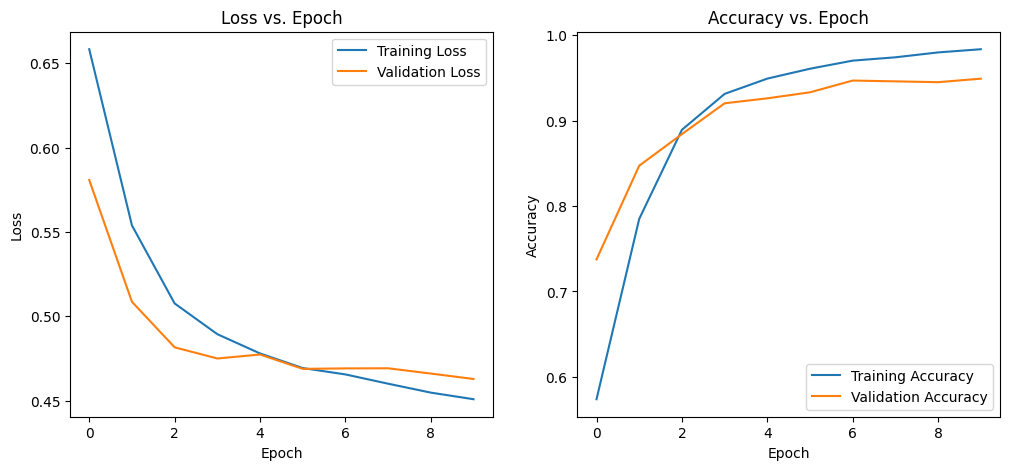

In [96]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epoch')

plt.show()

In [97]:
print('\nTest Set...')

test_preds = []

print('Total batches:', len(testdata))

for fold_index in range(0, 4):

    print('\nFold Model', fold_index)

    # Load the fold model
    path_model = 'bert_weights.pt'
    model.load_state_dict(torch.load(path_model))

    # Send the model to the GPU
    model.to(device)

    stacked_val_labels = []

    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    for j, test_batch in enumerate(testdata):

        inference_status = 'Batch ' + str(j + 1)

        print(inference_status, end='\r')

        b_input_ids = test_batch[0].to(device)
        b_input_mask = test_batch[1].to(device)
        b_token_type_ids = test_batch[2].to(device)
        b_sentiment_scores = test_batch[3].to(device)
        b_test_y = test_batch[4].to(device)



        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        token_type_ids=b_token_type_ids,
                        sentiment_scores=b_sentiment_scores)

        # Get the preds
        preds = outputs[0]

        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()

        #true_labels.append(b_test_y.to('cpu').numpy().flatten())

        # Stack the predictions.
        if j == 0:  # first batch
            stacked_val_preds = val_preds

        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))

    test_preds.append(stacked_val_preds)


print('\nPrediction complete.')


Test Set...
Total batches: 82

Fold Model 0


<ipython-input-97-aa70bb2244b8>:13: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

T


Fold Model 1

Fold Model 2

Fold Model 3

Prediction complete.


In [98]:
print(len(test_preds))
print(test_preds[:5])

4
[array([[0.2770141 , 0.69741374],
       [0.40560102, 0.6394173 ],
       [0.2919747 , 0.68657494],
       [0.2853722 , 0.68835783],
       [0.27107856, 0.6962482 ],
       [0.27589718, 0.691162  ],
       [0.28394714, 0.6891325 ],
       [0.27484086, 0.69834965],
       [0.28607383, 0.69081634],
       [0.27196956, 0.7017663 ],
       [0.26868418, 0.6968912 ],
       [0.2526905 , 0.70395595],
       [0.29019403, 0.6908659 ],
       [0.28161493, 0.69113123],
       [0.27844623, 0.6950914 ],
       [0.2916777 , 0.68847543],
       [0.28651166, 0.69193995],
       [0.27135298, 0.6995605 ],
       [0.29025817, 0.6897837 ],
       [0.26988763, 0.69985104],
       [0.27743188, 0.69047314],
       [0.26798823, 0.6993829 ],
       [0.34300914, 0.6683655 ],
       [0.2742587 , 0.6984368 ],
       [0.28971756, 0.68215114],
       [0.29846424, 0.6858453 ],
       [0.2905003 , 0.6884598 ],
       [0.28170592, 0.6908306 ],
       [0.9957814 , 0.03748629],
       [0.29132864, 0.6909336 ],
       

In [99]:
# Sum the predictions of all fold models
for i, item in enumerate(test_preds):
    if i == 0:
        preds = item
    else:
        # Sum the matrices
        preds = item + preds

# Average the predictions
avg_preds = preds/(len(test_preds))

#print(preds)
#print()
#print(avg_preds)

# Take the argmax.
# This returns the column index of the max value in each row.
test_predictions = np.argmax(avg_preds, axis=1)

# Take a look of the output
print(type(test_predictions))
print(len(test_predictions))
print()
print(test_predictions)

<class 'numpy.ndarray'>
82

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1]


In [100]:
true_y = []
for j, test_batch in enumerate(testdata):
    true_y.append(int(test_batch[3][0].numpy().flatten()))
print(true_y)

<ipython-input-100-339decd1dab9>:3: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


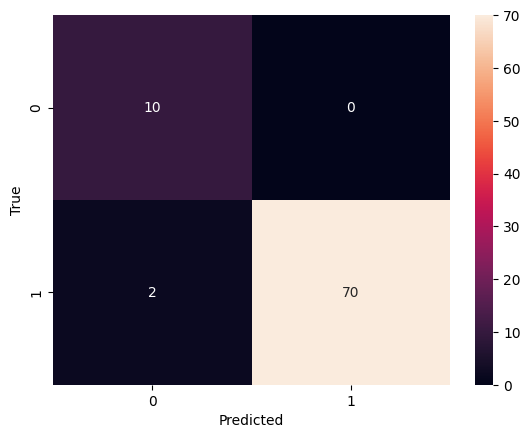

In [101]:
# Accuracy and classification report
target_names = ['true_y', 'predicted_y']

data = {'true_y': true_y,
       'predicted_y': test_predictions}

df_pred_BERT = pd.DataFrame(data, columns=['true_y','predicted_y'])

confusion_matrix = pd.crosstab(df_pred_BERT['true_y'], df_pred_BERT['predicted_y'], rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [102]:
print(classification_report(true_y, test_predictions))


              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.97      0.99        72

    accuracy                           0.98        82
   macro avg       0.92      0.99      0.95        82
weighted avg       0.98      0.98      0.98        82



In [103]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"Accuracy of BERT model, {accuracy_score(true_y, test_predictions) * 100:.4f}%")
print(f"Precision of BERT model, {precision_score(true_y, test_predictions) * 100:.4f}%")
print(f"Recall of BERT model, {recall_score(true_y, test_predictions) * 100:.4f}%")
print(f"F1_score of BERT model, {f1_score(true_y, test_predictions) * 100:.4f}%")


Accuracy of BERT model, 97.5610%
Precision of BERT model, 100.0000%
Recall of BERT model, 97.2222%
F1_score of BERT model, 98.5915%
